In [1]:
import pickle as pkl
from PIL import Image
from io import BytesIO
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'
%matplotlib inline

print("imported all")

imported all


In [2]:
save_dir = "../doc" 
CLR_PAL = [[c / 255. for c in (251, 132, 2)], 
           [c / 255. for c in (53, 183, 119)], 
           [c / 255. for c in (185, 55, 120)], ]

In [3]:
# results_folder = "./delta_outputs/Yuxiang_results/outputs/optimization-results/DIFFUSIONDB-opt-gpt-4o-mini-aggregate-True-2024-12-05-22-37-51/result_by_image"
results_folder = "./delta_outputs/Yuxiang_results2/outputs/optimization-results/DIFFUSIONDB-opt-gpt-4o-mini-aggregate-True-2024-12-06-23-26-36/result_by_image"
# results_folder = "./delta_outputs/Yuxiang_results2/outputs/optimization-results/DIFFUSIONDB-opt-gpt-4o-mini-aggregate-False-2024-12-06-23-26-08/result_by_image"

img_ids = []
opt_proc = []
for f in sorted(os.listdir(results_folder)):
    if not f.startswith('.') and f.endswith('csv'):
        img_ids.append(f.split(".")[0])
        opt_proc.append(pd.read_csv(os.path.join(results_folder, f), index_col=False).to_dict())
        
# opt_proc[0].head()

print("img_ids", len(img_ids), img_ids[0])
print("opt_proc", len(opt_proc), opt_proc[0].keys())
print(opt_proc[0]['step'])
print(opt_proc[0]['scores-total'])



img_ids 20 039af9d7-04f9-4d5f-bdc5-696a2f820627
opt_proc 20 dict_keys(['instructions', 'scores-rel', 'scores-aes', 'scores-total', 'step'])
{0: -1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3, 13: 4, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 6, 20: 6, 21: 6, 22: 7, 23: 7, 24: 7, 25: 8, 26: 8, 27: 8, 28: 9, 29: 9, 30: 9}
{0: 171.32759845220656, 1: 163.93464621794652, 2: 149.01183694766564, 3: 87.99980676015099, 4: 162.536875700257, 5: 147.0077611141705, 6: 149.39645956883174, 7: 18.430965345059946, 8: 156.0042530881807, 9: 156.54277213847635, 10: 177.42549386095928, 11: 142.51122271827342, 12: 154.86206296351466, 13: 143.77365366763584, 14: 128.2587895753666, 15: 125.0501249883135, 16: 148.19217801811644, 17: 160.3862827327914, 18: 148.31210367473273, 19: 150.93795068197775, 20: 133.03513547085765, 21: 121.7997260527969, 22: 152.5656827802049, 23: 143.4258382813124, 24: 163.2735807202194, 25: 182.81542188582972, 26: 160.2585997955289, 27: 157.0630174717719, 28

In [22]:
steps = 11 # 20 steps + 1 for initial image
scores_rel = np.full((len(img_ids), steps), np.nan)
scores_aes = np.full((len(img_ids), steps), np.nan)
scores_tot = np.full((len(img_ids), steps), np.nan)

reduce = np.nanmax  # np.nanmedian, np.nanmax, np.nanmean
do_norm = True

for i, iid in enumerate(img_ids):
    curr_steps = np.asarray(list(opt_proc[i]["step"].values()), dtype=int) + 1 # 1 for initial image
    curr_rel = np.asarray(list(opt_proc[i]["scores-rel"].values()), dtype=float)
    curr_aes = np.asarray(list(opt_proc[i]["scores-aes"].values()), dtype=float)
    try:
        curr_tot = np.asarray(list(opt_proc[i]["scores-total"].values()), dtype=float)
    except KeyError:
        curr_tot = curr_rel / 4. + curr_aes  # 4.: normalization factor for scale diff
    for j in range(steps):
        mask = curr_steps == j
        if np.sum(mask) > 0:
            scores_rel[i, j] = reduce(curr_rel[mask])
            scores_aes[i, j] = reduce(curr_aes[mask])
            scores_tot[i, j] = reduce(curr_tot[mask])
    # print(scores_rel[i])
    # break
print("scores_rel", scores_rel.shape, scores_rel[0])

if do_norm:
    scores_rel = scores_rel / scores_rel[:, 0][:, np.newaxis]
    scores_aes = scores_aes / scores_aes[:, 0][:, np.newaxis]
    scores_tot = scores_tot / scores_tot[:, 0][:, np.newaxis]
print("scores_rel", scores_rel.shape, scores_rel[0])



scores_rel (20, 11) [35. 34. 35. 35. 35. 35. 35. 35. 35. 35. 35.]
scores_rel (20, 11) [1.         0.97142857 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [23]:
data_reform = "med_quart"  # "mean_std", "med_quart"
if data_reform == "mean_std":
    x_ax = np.arange(steps)
    y_avg_rel = np.nanmean(scores_rel, axis=0)
    y_avg_aes = np.nanmean(scores_aes, axis=0)
    y_avg_tot = np.nanmean(scores_tot, axis=0)

    y_std_rel = np.nanstd(scores_rel, axis=0)
    y_std_aes = np.nanstd(scores_aes, axis=0)
    y_std_tot = np.nanstd(scores_tot, axis=0)
else:
    x_ax = np.arange(steps)
    y_avg_rel = np.nanmedian(scores_rel, axis=0)
    y_avg_aes = np.nanmedian(scores_aes, axis=0)
    y_avg_tot = np.nanmedian(scores_tot, axis=0)

    y_q1_rel = np.nanpercentile(scores_rel, 25, axis=0)
    y_q1_aes = np.nanpercentile(scores_aes, 25, axis=0)
    y_q1_tot = np.nanpercentile(scores_tot, 25, axis=0)

    y_q3_rel = np.nanpercentile(scores_rel, 75, axis=0)
    y_q3_aes = np.nanpercentile(scores_aes, 75, axis=0)
    y_q3_tot = np.nanpercentile(scores_tot, 75, axis=0)


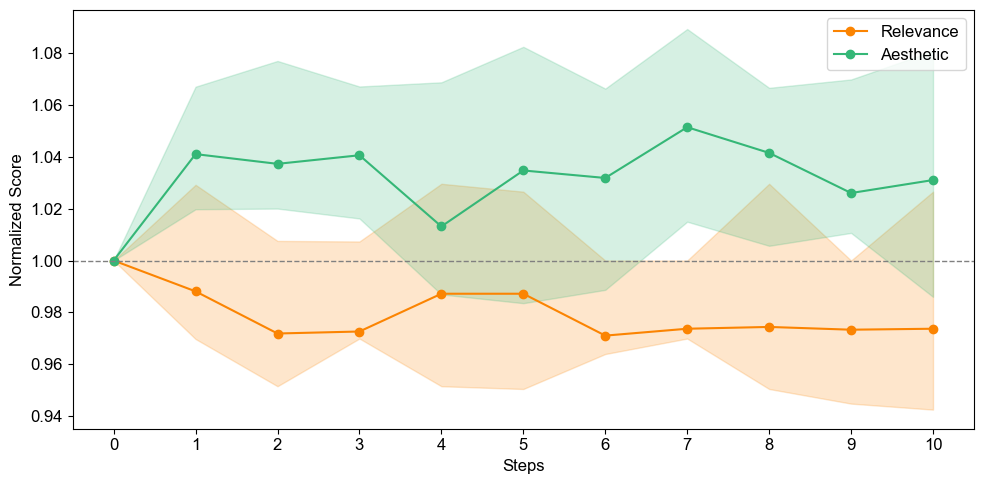

In [24]:
ax, fig = plt.subplots(1, 1, figsize=(10, 5))

if data_reform == "mean_std":
    plt.errorbar(x_ax, y_avg_rel, yerr=y_std_rel, fmt='-o', label='relevance score', color=CLR_PAL[0])
    plt.errorbar(x_ax, y_avg_aes, yerr=y_std_aes, fmt='-o', label='aesthetic score', color=CLR_PAL[1])
    plt.errorbar(x_ax, y_avg_tot, yerr=y_std_tot, fmt='-o', label='total score', color=CLR_PAL[2])
else:
    plt.fill_between(x_ax, y_q1_rel, y_q3_rel, alpha=0.2, color=CLR_PAL[0])
    plt.fill_between(x_ax, y_q1_aes, y_q3_aes, alpha=0.2, color=CLR_PAL[1])
    if "aggregate-True" in results_folder:
        plt.fill_between(x_ax, y_q1_tot, y_q3_tot, alpha=0.2, color=CLR_PAL[2])
        plt.plot(x_ax, y_avg_tot, '-o', label='Total', color=CLR_PAL[2])
    plt.plot(x_ax, y_avg_rel, '-o', label='Relevance', color=CLR_PAL[0])
    plt.plot(x_ax, y_avg_aes, '-o', label='Aesthetic', color=CLR_PAL[1])
    

plt.axhline(1, color='grey', linestyle='--', linewidth=1)
plt.ylabel('Normalized Score')
plt.xticks(x_ax)
plt.xlabel('Steps')
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/scores_agg_{'True' if 'aggregate-True' in results_folder else 'False'}.png", dpi=300)

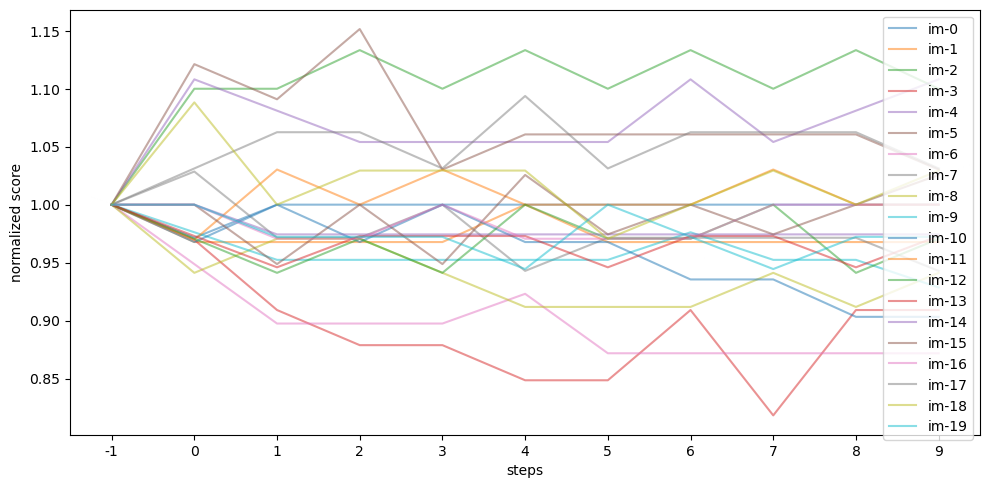

In [55]:
ax, fig = plt.subplots(1, 1, figsize=(10, 5))
for i in range(scores_tot.shape[0]):
    plt.plot(x_ax, scores_rel[i], alpha=0.5, label=f"im-{i}")

plt.ylabel('normalized score')
plt.xticks(x_ax, labels=[str(i - 1) for i in x_ax])
# plt.xticks_label = [str(i - 1) for i in x_ax]
plt.xlabel('steps')
plt.legend()
plt.tight_layout()


im_pth 039af9d7-04f9-4d5f-bdc5-696a2f820627
[-1  0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7
  7  8  8  8  9  9  9]
['dragon portrait, artstation, pixar render, high quality, wings of fire ']
[35.]
[5.94593573]


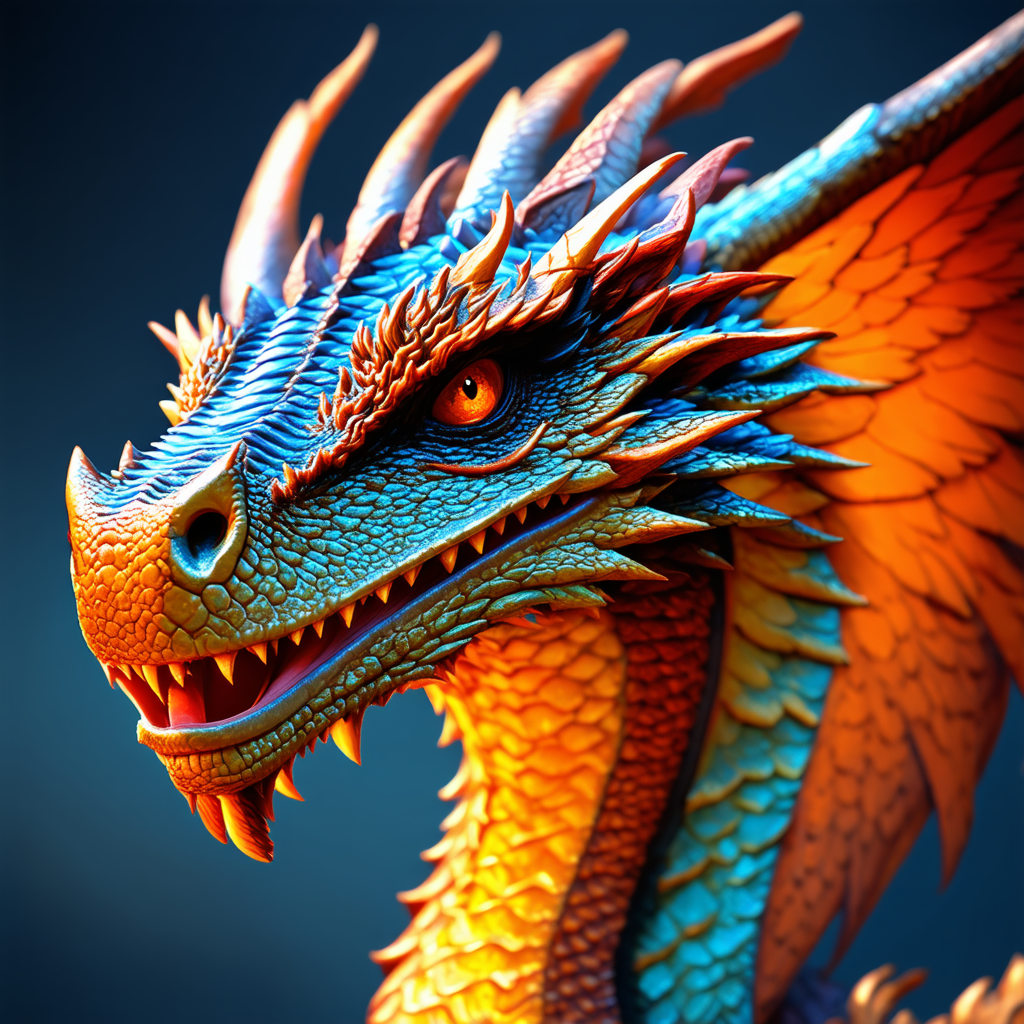

In [8]:
# im_pth = "./delta_outputs/"
# im_pth += "DIFFUSIONDB-opt-gpt-4o-mini-aggregate-True-2024-12-05-21-34-14/result_by_image/ad50dd2b-e60c-4725-a8a5-be47f423000f-step--1.pkl"

which_step = -1
which_img = 0
which_prompt = 0

im_pth = os.path.join(results_folder, img_ids[which_img] + f"-step-{which_step}.pkl")
print("im_pth", img_ids[which_img])

prompts = np.asarray(list(opt_proc[which_img]["instructions"].values()))
rel_scores = np.asarray(list(opt_proc[which_img]["scores-rel"].values()))
aes_scores = np.asarray(list(opt_proc[which_img]["scores-aes"].values()))
img_steps = np.asarray(list(opt_proc[which_img]["step"].values()))
print(img_steps)
print(prompts[img_steps == which_step])
print(rel_scores[img_steps == which_step])
print(aes_scores[img_steps == which_step])

with open(im_pth, "rb") as f:
    img_bytes_ls = pkl.load(f)
img_bytes = img_bytes_ls[which_prompt]
buffer = BytesIO(img_bytes)
img = Image.open(buffer)
display(img)
# img.show()